# Module 13: Texts

We'll use `spaCy` and `wordcloud` to play with text data. `spaCy` is probably the best python package for analyzing text data. It's capable and super fast. Let's install them. 

    pip install wordcloud spacy
    
To use spaCy, you also need to download models. Run: 

    python -m spacy download en
    

## SpaCy basics

In [1]:
import spacy
import wordcloud

nlp = spacy.load('en')

Usually the first step of text analysis is _tokenization_, which is the process of breaking a document into "tokens". You can roughly think of it as extracting each word. 

In [2]:
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

for token in doc:
    print(token)

Apple
is
looking
at
buying
U.K.
startup
for
$
1
billion


As you can see, it's not exactly same as `doc.split()`. You'd want to have `$` as a separate token because it has a particular meaning (USD). Actually, as shown in an example (https://spacy.io/usage/spacy-101#annotations-pos-deps), `spaCy` figures out a lot of things about these tokens. For instance, 

In [3]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_)

Apple apple PROPN NNP
is be VERB VBZ
looking look VERB VBG
at at ADP IN
buying buy VERB VBG
U.K. u.k. PROPN NNP
startup startup NOUN NN
for for ADP IN
$ $ SYM $
1 1 NUM CD
billion billion NUM CD


It figured it out that `Apple` is a proper noun ("PROPN" and "NNP"; see [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for the part of speech tags). 

`spaCy` has a visualizer too. 

In [4]:
from spacy import displacy
displacy.render(doc, style='dep', jupyter=True, options={'distance': 100})

It even recognizes entities and can visualize them. 

In [5]:
text = """But Google is starting from behind. The company made a late push
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa
software, which runs on its Echo and Dot devices, have clear leads in
consumer adoption."""

doc2 = nlp(text)
displacy.render(doc2, style='ent', jupyter=True)

## Let's read a book

Shall we load some serious book? You can use any books that you can find as a text file. 

In [6]:
import urllib.request

metamorphosis_book = urllib.request.urlopen('http://www.gutenberg.org/cache/epub/5200/pg5200.txt').read()

In [7]:
metamorphosis_book[:1000]

b'\xef\xbb\xbfThe Project Gutenberg EBook of Metamorphosis, by Franz Kafka\r\nTranslated by David Wyllie.\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.net\r\n\r\n** This is a COPYRIGHTED Project Gutenberg eBook, Details Below **\r\n**     Please follow the copyright guidelines in this file.     **\r\n\r\n\r\nTitle: Metamorphosis\r\n\r\nAuthor: Franz Kafka\r\n\r\nTranslator: David Wyllie\r\n\r\nRelease Date: August 16, 2005 [EBook #5200]\r\nFirst posted: May 13, 2002\r\nLast updated: May 20, 2012\r\n\r\nLanguage: English\r\n\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK METAMORPHOSIS ***\r\n\r\n\r\n\r\n\r\nCopyright (C) 2002 David Wyllie.\r\n\r\n\r\n\r\n\r\n\r\n  Metamorphosis\r\n  Franz Kafka\r\n\r\nTranslated by David Wyllie\r\n\r\n\r\n\r\nI\r\n\r\n\r\nOne morning, when

Looks like we have successfully loaded the book. You'd probably want to remove the parts at the beginning and at the end that are not parts of the book if you are doing a serious analysis, but let's ignore them for now. Let's try to feed this directly into `spaCy`.  

In [8]:
doc_metamor = nlp(metamorphosis_book)

TypeError: Argument 'string' has incorrect type (expected str, got bytes)

## On encodings

Why are we getting this error? What does it mean? It says `nlp` function expects `str` type but we passed `bytes`. 

In [9]:
type(metamorphosis_book)

bytes

Indeed, the type of `metamorphosis_book` is `bytes`. But as we have seen above, we can see the book contents right? What's going on? 

Well, the problem is that a byte sequence is not yet a proper string until we know how to decode it. A string is an abstract object and we need to specify an encoding to write the string into a file. For instance, if I have a string of Korean characters like "안녕", there are several encodings that I can specify to write that into a file, and depending on the encoding that I choose, the byte sequences can be totally different from each other. This is a really important (and confusing) topic, but because it's beyond the scope of the course, I'll just link a nice post about encoding: http://kunststube.net/encoding/

In [10]:
"안녕".encode('utf8')

b'\xec\x95\x88\xeb\x85\x95'

In [11]:
# b'\xec\x95\x88\xeb\x85\x95'.decode('euc-kr') <- what happen if you do this?
b'\xec\x95\x88\xeb\x85\x95'.decode('utf8')

'안녕'

In [12]:
"안녕".encode('euc-kr')

b'\xbe\xc8\xb3\xe7'

In [13]:
b'\xbe\xc8\xb3\xe7'.decode('euc-kr')

'안녕'

You can decode with "wrong" encoding too. 

In [14]:
b'\xbe\xc8\xb3\xe7'.decode('latin-1')

'¾È³ç'

As you can see the same string can be encoded into different byte sequences depending on the encoding. It's a really ~~annoying~~ fun topic and if you need to deal with text data, you must have a good understanding of it. 

I know that Project Gutenberg uses `utf-8` encoding. So let's decode the byte sequence into a string. 

In [15]:
metamorphosis_book_str = metamorphosis_book.decode('utf8')
type(metamorphosis_book_str)

str

Shall we try again?

In [16]:
doc_metamor = nlp(metamorphosis_book_str)

In [17]:
words = [token.text for token in doc_metamor 
         if token.is_stop != True and token.is_punct != True]

## Let's count!

In [18]:
from collections import Counter

Counter(words).most_common(5)

[('\r\n', 1970), (' ', 670), ('Gregor', 298), ("'s", 199), ('\r\n\r\n', 148)]

a lot of newline characters and multiple spaces. A quick and dirty way to remove them is split & join. 

In [19]:
doc_metamor = nlp(' '.join(metamorphosis_book_str.split()))
words = [token.text for token in doc_metamor
         if token.is_stop != True and token.is_punct != True]
Counter(words).most_common(10)

[('Gregor', 298),
 ("'s", 199),
 ('room', 131),
 ('sister', 101),
 ('father', 99),
 ('I', 90),
 ('door', 87),
 ('He', 85),
 ('mother', 85),
 ('Project', 84)]

In [20]:
word_cnt = Counter(words)

## Some wordclouds?

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
wc = wordcloud.WordCloud(width=1000, height=500)
wc.generate_from_frequencies(word_cnt)

(-0.5, 999.5, 499.5, -0.5)

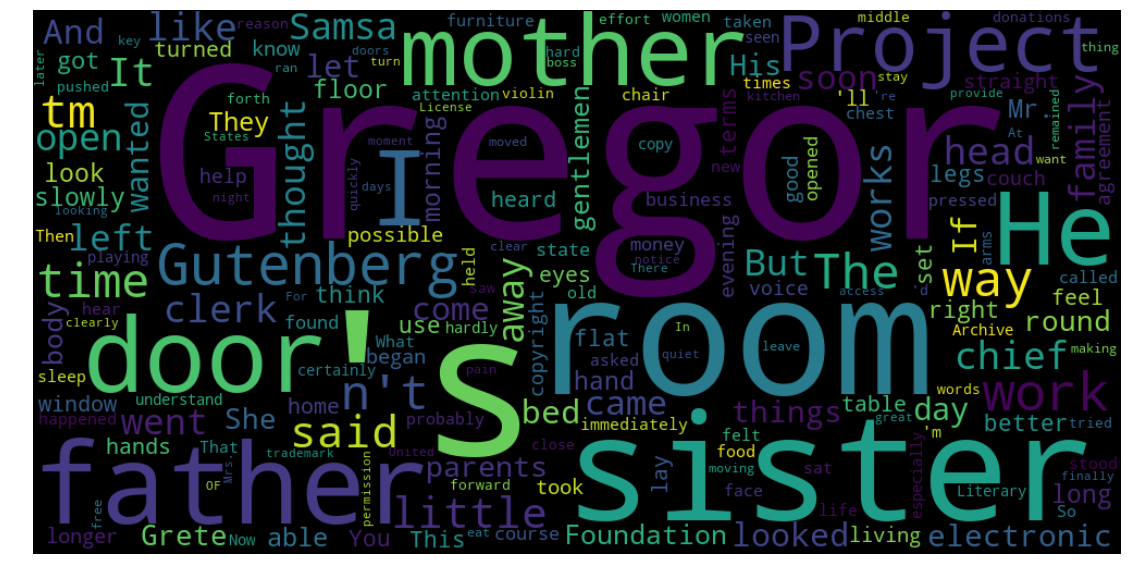

In [23]:
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

**Q: Can you create a word cloud for a certain part of speech, such as nouns, verbs, proper nouns, etc.?**

##### Proper Noun WordCloud

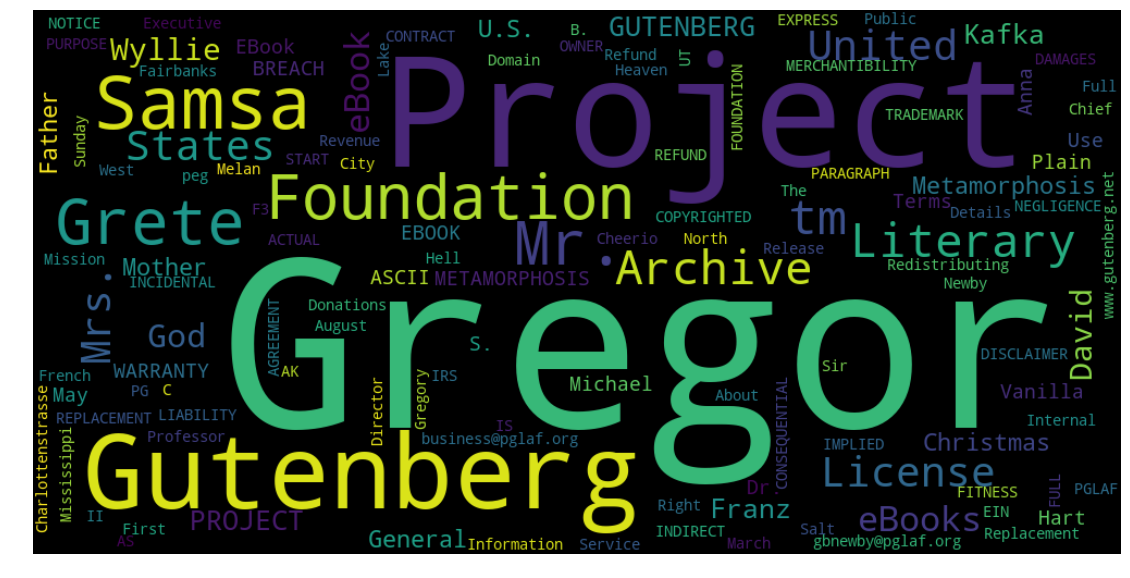

In [24]:
doc_metamor = nlp(' '.join(metamorphosis_book_str.split()))
words = [token.text for token in doc_metamor
         if token.pos_ == "PROPN"]

word_cnt = Counter(words)

wc = wordcloud.WordCloud(width=1000, height=500)
wc.generate_from_frequencies(word_cnt)

plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off");

In [25]:
##### Verb Noun WordCloud

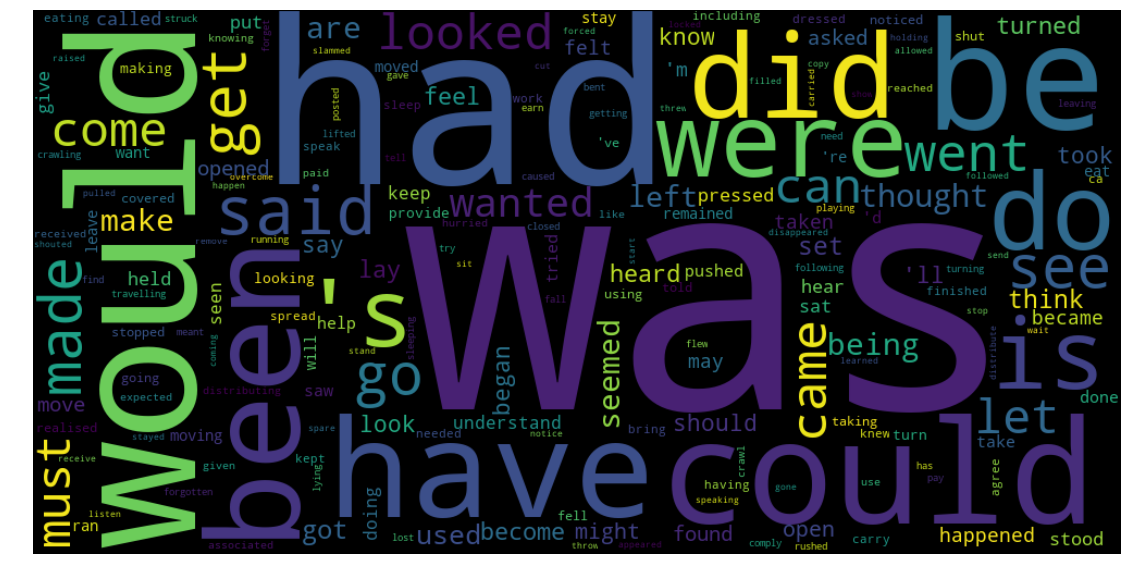

In [26]:
doc_metamor = nlp(' '.join(metamorphosis_book_str.split()))
words = [token.text for token in doc_metamor
         if token.pos_ == "VERB"]

word_cnt = Counter(words)

wc = wordcloud.WordCloud(width=1000, height=500)
wc.generate_from_frequencies(word_cnt)

plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off");

In [27]:
##### Noun WordCloud

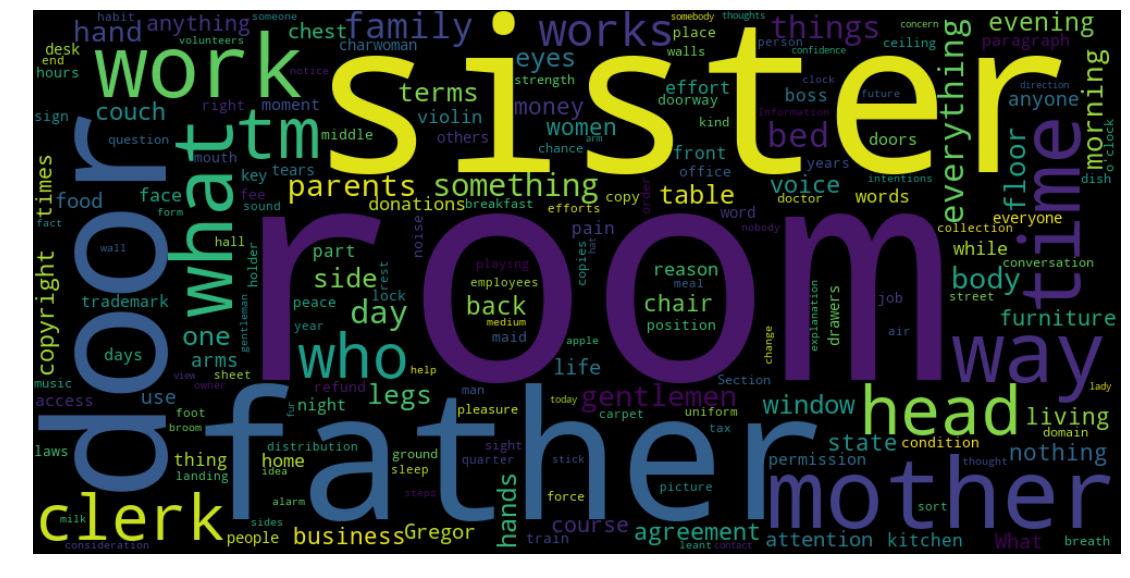

In [28]:
doc_metamor = nlp(' '.join(metamorphosis_book_str.split()))
words = [token.text for token in doc_metamor
         if token.pos_ == "NOUN"]

word_cnt = Counter(words)

wc = wordcloud.WordCloud(width=1000, height=500)
wc.generate_from_frequencies(word_cnt)

plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off");